In [122]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt

# A neural network

### This is a neural network which checks whether the sum of two numbers is positive or negative

In [123]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [124]:
def F(x, p, layers):
    assert x.shape[0] == layers[0]
    
    W = []
    b = []
    index = 0
    for i in range(len(layers) - 1):
        W.append(p[index:index + layers[i] * layers[i + 1]].reshape((layers[i + 1], layers[i])))
        index += layers[i] * layers[i + 1]
    for i in range(len(layers) - 1):
        b.append(p[index:index + layers[i + 1]])
        index += layers[i + 1]
    
    a = x
    for i in range(len(layers) - 1):
        a = sigmoid(W[i] @ a + b[i])
    y = a
    
    assert y.shape[0] == layers[-1]
    
    return y

In [125]:
def f(p, layers, X, Y):
    res = np.array([np.linalg.norm(F(x, p, layers) - y) for x, y in zip(X, Y)])
    return res

In [126]:
def grad_C(p, layers, x, y):
    assert x.shape[0] == layers[0]
    assert y.shape[0] == layers[-1]
    
    W = []
    b = []
    index = 0
    for i in range(len(layers) - 1):
        W.append(p[index:index + layers[i] * layers[i + 1]].reshape((layers[i + 1], layers[i])))
        index += layers[i] * layers[i + 1]
    for i in range(len(layers) - 1):
        b.append(p[index:index + layers[i + 1]])
        index += layers[i + 1]
    
    a = [x]
    z = []
    for i in range(len(layers) - 1):
        z.append(W[i] @ a[i] + b[i])
        a.append(sigmoid(z[i]))
    
    delta = [sigmoid(z[-1]) * (1 - sigmoid(z[-1])) * (a[-1] - y)]
    for i in range(len(layers) - 2, 0, -1):
        delta.append(sigmoid(z[i - 1]) * (1 - sigmoid(z[i - 1])) * (W[i].T @ delta[-1]))
    delta = delta[::-1]
    
    grad_W = []
    for i in range(len(layers) - 1):
        grad_W.append(delta[i].reshape((layers[i + 1], 1)) @ a[i].reshape((1, layers[i])))
    
    grad_b = delta
    
    grad = np.concatenate(([grad_W[i].flatten() for i in range(len(grad_W))] + [grad_b[i] for i in range(len(grad_b))]))
    
    assert grad.shape == p.shape
    
    return grad

In [127]:
def hess_C(p, layers, x, y):
    assert x.shape[0] == layers[0]
    assert y.shape[0] == layers[-1]
    
    W = []
    b = []
    index = 0
    for i in range(len(layers) - 1):
        W.append(p[index:index + layers[i] * layers[i + 1]].reshape((layers[i + 1], layers[i])))
        index += layers[i] * layers[i + 1]
    for i in range(len(layers) - 1):
        b.append(p[index:index + layers[i + 1]])
        index += layers[i + 1]
    
    a = [x]
    z = []
    for i in range(len(layers) - 1):
        z.append(W[i] @ a[i] + b[i])
        a.append(sigmoid(z[i]))
    
    delta = [sigmoid(z[-1]) * (1 - sigmoid(z[-1])) * (a[-1] - y)]
    for i in range(len(layers) - 2, 0, -1):
        delta.append(sigmoid(z[i - 1]) * (1 - sigmoid(z[i - 1])) * (W[i].T @ delta[-1]))
    delta = delta[::-1]
    
    grad_W = []
    for i in range(len(layers) - 1):
        grad_W.append(delta[i].reshape((layers[i + 1], 1)) @ a[i].reshape((1, layers[i])))
    
    grad_b = delta
    
    grad = np.concatenate(([grad_W[i].flatten() for i in range(len(grad_W))] + [grad_b[i] for i in range(len(grad_b))]))
    
    hess_W = []
    for i in range(len(layers) - 1):
        hess_W.append(np.zeros((layers[i + 1] * layers[i], layers[i + 1] * layers[i])))
        for j in range(layers[i + 1]):
            for k in range(layers[i]):
                hess_W[i][j * layers[i] + k][j * layers[i] + k] = sigmoid(z[i][j]) * (1 - sigmoid(z[i][j])) * a[i][k]
    
    hess_b = []
    for i in range(len(layers) - 1):
        hess_b.append(np.zeros((layers[i + 1], layers[i + 1])))
        for j in range(layers[i + 1]):
            hess_b[i][j][j] = sigmoid(z[i][j]) * (1 - sigmoid(z[i][j]))

    hess = np.zeros((p.shape[0], p.shape[0]))
    index = 0
    for i in range(len(layers) - 1):
        hess[index:index + layers[i + 1] * layers[i], index:index + layers[i + 1] * layers[i]] = hess_W[i]
        index += layers[i + 1] * layers[i]
    for i in range(len(layers) - 1):
        hess[index:index + layers[i + 1], index:index + layers[i + 1]] = hess_b[i]
        index += layers[i + 1]

    assert hess.shape == (p.shape[0], p.shape[0])

    return hess

# Data

$X_i$ - random 2 dimentional vector with entries from -50 to 50

$Y_i$ - sum of entries of $X$ is greater than or equal 0

In [128]:
np.random.seed(3)
num_samples = 1000
X = 100 * np.random.rand(num_samples, 2) - 50
Y = (X[:, 0] + X[:, 1] >= 0).astype(float).reshape((num_samples, 1))
X[:5, :], Y[:5]

(array([[  5.07979026,  20.81478226],
        [-20.90952611,   1.08276052],
        [ 39.29469543,  39.62930889],
        [-37.44146895, -29.27571219],
        [-44.85327967,  -5.91901563]]),
 array([[1.],
        [0.],
        [1.],
        [0.],
        [0.]]))

## The function

In [129]:
layers = [2, 4, 4, 1]

def r(p):
    return f(p, layers, X, Y)

def Dr(p):
    return np.vstack([grad_C(p, layers, x, y) for x, y in zip(X, Y)])

def Hr(p):
    return np.vstack([hess_C(p, layers, x, y) for x, y in zip(X, Y)])

M = X.shape[0]
N = 0
for i in range(len(layers) - 1):
    N += layers[i] * layers[i + 1]
for i in range(len(layers) - 1):
    N += layers[i + 1]
N, M

(37, 1000)

In [130]:
R = Function(F=r, DF=Dr, D2F=Hr, N=N, M=M)

# Test different methods

Running Newton


Newton:   0%|          | 0/50 [00:00<?, ?it/s]

Newton:  48%|████▊     | 24/50 [00:17<00:18,  1.38it/s]C:\Users\matip\AppData\Local\Temp\ipykernel_5208\3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
Newton: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Running Gauss-Newton


Gauss-Newton: 100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


Running Gradient descent


Gradient descent: 100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


Running Levenberg-Marquardt


Levenberg-Marquardt: 100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


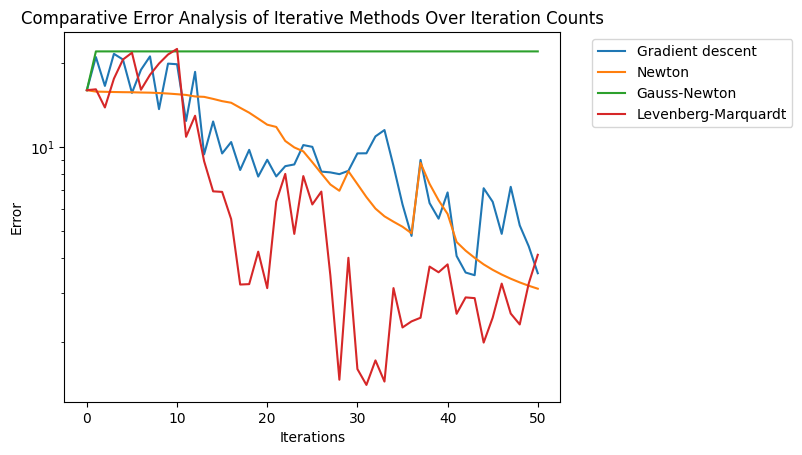

In [131]:
max_iter = 50
np.random.seed(1)
p0 = np.random.randn(N) / np.sqrt(N)
alpha_gd = 1e-1
alpha_gn = 1.0
lambda0 = 1.0

NEWTON = "Newton"
GAUSS_NEWTON = "Gauss-Newton"
GRADIENT_DESCENT = "Gradient descent"
LEVENBERG_MARQUARDT_CONST_PARAM = "Levenberg-Marquardt"
optimizer_names = [
    GRADIENT_DESCENT,
    NEWTON,
    GAUSS_NEWTON,
    LEVENBERG_MARQUARDT_CONST_PARAM,
]

errors = {name: [] for name in optimizer_names}
points = {name: [] for name in optimizer_names}

optimizer_functions = {
    NEWTON: lambda points, errs: newton(R=R, p0=p0, max_iter=max_iter, alpha=alpha_gn, points=points, errs=errs),
    GAUSS_NEWTON: lambda points, errs: gauss_newton(R=R, p0=p0, alpha=alpha_gn, max_iter=max_iter, points=points, errs=errs),
    GRADIENT_DESCENT: lambda points, errs: gradient_descent(R=R, p0=p0, alpha=alpha_gd, max_iter=max_iter, points=points, errs=errs),
    LEVENBERG_MARQUARDT_CONST_PARAM: lambda points, errs: (
        LevenbergMarquardt(R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0))
        .optimize(p0, max_iter, points=points, errs=errs)
    ),
}

for name, optimizer in optimizer_functions.items():
    print("Running " + name)
    optimizer(points=points[name], errs=errors[name])

iters = np.arange(0, max_iter + 1)
for label, err in errors.items():
    try:
        plt.plot(iters, err, label=label)
    except:
        print("error in plotting for " + label)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.title("Comparative Error Analysis of Iterative Methods Over Iteration Counts")
plt.show()

In [134]:
errors[NEWTON][-1], errors[GAUSS_NEWTON][-1], errors[GRADIENT_DESCENT][-1], errors[LEVENBERG_MARQUARDT_CONST_PARAM][-1]

(3.1000633386296155, 22.02271554554524, 3.5227373995414295, 4.101767902687757)

In [149]:
# tests
params = points[NEWTON][-1]

X_test = [
    np.array([1, 2]), np.array([-1, 2]), np.array([-1, -2]), np.array([1, -2]), np.array([10, -11]), np.array([-10, 11]), np.array([-14, 18])
]
Y_test = [np.array([x[0] + x[1] >= 0]).astype(float) for x in X_test]

for i, (x, y) in enumerate(zip(X_test, Y_test)):
    print("Test " + str(i + 1) + ":")
    print("x = " + str(x))
    print("y = " + str(y))
    print("F(x) = " + str(F(x, params, layers)))
    print("error = " + str(np.linalg.norm(F(x, params, layers) - y)))
    print(f"result: {'correct' if np.linalg.norm(F(x, params, layers) - y) < 0.5 else 'incorrect'}")
    print()

Test 1:
x = [1 2]
y = [1.]
F(x) = [0.89460419]
error = 0.10539581089509986
result: correct

Test 2:
x = [-1  2]
y = [1.]
F(x) = [0.93803876]
error = 0.06196124155613625
result: correct

Test 3:
x = [-1 -2]
y = [0.]
F(x) = [0.09136172]
error = 0.09136172293928789
result: correct

Test 4:
x = [ 1 -2]
y = [0.]
F(x) = [0.07410693]
error = 0.07410692901450315
result: correct

Test 5:
x = [ 10 -11]
y = [0.]
F(x) = [0.08641772]
error = 0.08641771755185226
result: correct

Test 6:
x = [-10  11]
y = [1.]
F(x) = [0.90428252]
error = 0.09571747991046553
result: correct

Test 7:
x = [-14  18]
y = [1.]
F(x) = [0.90423211]
error = 0.09576788681581183
result: correct

